In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

import myLib_barChart as myBar
import myLib_confMatrix as myMatrix
import myLib_parseData as myParse
import myLib_pieChart as myPie
import myLib_table as myTable
import myLib_testModel as myTest
from myLib_testModel import letterToSoftmax
import myLib_writeFile as myWrite
import myLib_debugFiles as myDebug


np.set_printoptions(suppress=True)

In [2]:
# DEfinition of string values for the bold print
S_BOLD = '\033[1m'
E_BOLD = '\033[0m'

# LOAD DATASET AND PREPARE TRAIN - TEST

In this section the functions loadDataFromTxt and parseTrainTest are called. These allow to load the dataset from the txt files into matrices and then separate them in smaller matrices for testing and training. 

Select DATASET_TO_LOAD 1 if you want to randomize the data for the OL 

Select DATASET_TO_LOAD 2 if you want to use an already mixed dataset that is the same of the STM application

In [3]:
DATASET_TO_LOAD = 2      # 1 for the randomization | 2 for the same dataset as the STM pplication
DEBUG_HISTORY   = 1      # 0 for no debug          | 1 for yes debug

In [4]:
vowels_data, vowels_label = myParse.loadDataFromTxt('vowels_OL')
OL_data_train_vow, OL_label_train_vow, OL_data_test_vow, OL_label_test_vow = myParse.parseTrainTest(vowels_data, vowels_label, 0.7)
    

if(DATASET_TO_LOAD == 1):
    
    B_data, B_label = myParse.loadDataFromTxt('B_dataset')
    B_train_data, B_train_label, B_test_data, B_test_label = myParse.parseTrainTest(B_data, B_label, 0.7)
    
    M_data, M_label = myParse.loadDataFromTxt('M_dataset')
    M_train_data, M_train_label, M_test_data, M_test_label = myParse.parseTrainTest(M_data, M_label, 0.7)
    
    R_data, R_label = myParse.loadDataFromTxt('R_dataset')
    R_train_data, R_train_label, R_test_data, R_test_label = myParse.parseTrainTest(R_data, R_label, 0.7)

******* Dataset for letter ['A' 'E' 'I' 'O' 'U']

Raw shape        -> (103600, 5)
Tot samples      -> 518


*** Separate train-valid

Train data shape  -> (361, 600)
Test data shape   -> (155, 600)


###  Create a dataset of all letters

In this smaller section all the previous matrices are stacked together and then shuffled in order to create two big matrices that contain all the letters for training and testing. The training dataset is also shuffled, in order to shuffle it differently change the seed value inside the function myParse.shuffleDataset

In [5]:
if(DATASET_TO_LOAD == 1):
    # Create a matrix that contains all the train data
    data_all = OL_data_train_vow
    data_all = np.vstack(( data_all, B_train_data))
    data_all = np.vstack(( data_all, R_train_data))
    data_all = np.vstack(( data_all, M_train_data))
    # Create an array that contains all the train labels
    label_all = OL_label_train_vow
    label_all = np.hstack(( label_all, B_train_label))
    label_all = np.hstack(( label_all, R_train_label))
    label_all = np.hstack(( label_all, M_train_label))
    # Shuffle the matrix and the label
    data_all, label_all = myParse.shuffleDataset(data_all, label_all)

    print('data_all has shape  ' + str(data_all.shape))
    print('label_all has shape ' + str(label_all.shape))

In [6]:
if(DATASET_TO_LOAD == 1):
    # Create a matrix that contains all the train data
    data_test = OL_data_test_vow
    data_test = np.vstack(( data_test, B_test_data))
    data_test = np.vstack(( data_test, R_test_data))
    data_test = np.vstack(( data_test, M_test_data))
    # Create an array that contains all the train labels
    label_test = OL_label_test_vow
    label_test = np.hstack(( label_test, B_test_label))
    label_test = np.hstack(( label_test, R_test_label))
    label_test = np.hstack(( label_test, M_test_label))

    print('data_test has shape  ' + str(data_test.shape))
    print('label_test has shape ' + str(label_test.shape))

Another method for loading the dataset is to load it from the txt file "training_file". This file is an already shuffled dataset. I can use this for both feeding data in this simulation and also to the STM in order to have the closes behaviour possible.

In [7]:
if(DATASET_TO_LOAD == 2):
    data, label = myParse.loadDataFromTxt('training_file_2')
    data_train, label_train, data_test, label_test = myParse.parseTrainTest(data, label, 0.5)

******* Dataset for letter ['A' 'B' 'E' 'I' 'M' 'O' 'R' 'U']

Raw shape        -> (381000, 5)
Tot samples      -> 1905


*** Separate train-valid

Train data shape  -> (951, 600)
Test data shape   -> (952, 600)


The class Data_Container is just a container that I created in order to have all the dataset in a single object. This is useful for the plotting functions because it allows me to give as input to the function just one object and not the entire list of datasets.

In [8]:
class Data_Container(object):
    def __init__(self):

        self.R_test_data       = R_test_data
        self.R_test_label      = R_test_label
        self.B_test_data       = B_test_data
        self.B_test_label      = B_test_label
        self.M_test_data       = M_test_data
        self.M_test_label      = M_test_label
        self.R_test_data       = R_test_data
        self.OL_data_test_vow  = OL_data_test_vow
        self.OL_label_test_vow = OL_label_test_vow
        
#OL_testing_data = Data_Container()

### Check the content of the dataset

This block is used only to check the type of letters that are inside the datasets that I imported. It's used in order to see if the datasets are created and saved correctly.

In [9]:
print('\nTRAIN DATASET SANITY CHECK')
myParse.sanityCheckDataset(label_train)
print('\nTEST DATASET SANITY CHECK')
myParse.sanityCheckDataset(label_test)


TRAIN DATASET SANITY CHECK
    The letters found are:              ['O', 'E', 'B', 'A', 'M', 'R', 'U', 'I']
    And for each letter the counter is: [115. 104. 144. 108. 137. 141. 106.  95.   1.]

TEST DATASET SANITY CHECK
    The letters found are:              ['M', 'B', 'O', 'I', 'U', 'R', 'E', 'A']
    And for each letter the counter is: [141. 158.  89. 110.  98. 159. 100.  96.   1.]


#  ------------------------------------------------------------------------

# LOAD TF TRAINED MODEL

In this section I load the frozen model. The frozen model is the NN that has been trained with keras on the PC. The script that trains this model is called 'run_trainFroznModel.py'

In [10]:
ROOT_PATH = os.path.abspath('')
MODEL_PATH = ROOT_PATH + "/Saved_models/"

In [11]:
model = keras.models.load_model(MODEL_PATH + 'Original_model/model.h5')

#  ------------------------------------------------------------------------

# TINY OL

In this section the main part of the continual learning study is found. Here can be found the functions used for implementing the different algorithms. 

The function below is an implementation of the softmx function. I had to use this because I noticed that the sofmtax function used from keras and other methods for computing the sotmax operation gave different results.

In [12]:
def myFunc_softmax(array):
    """ Computes softmax of an array
    
    Parameters
    ----------
    array : array_like
        Is the array of which I want to compute the softmax operation
    """
    
    if(len(array.shape)==2):
        array = array[0]
        
    size    = len(array)
    ret_ary = np.zeros([len(array)])
    m       = array[0]
    sum_val = 0

    for i in range(0, size):
        if(m<array[i]):
            m = array[i]

    for i in range(0, size):
        sum_val += np.exp(array[i] - m)

    constant = m + np.log(sum_val)
    for i in range(0, size):
        ret_ary[i] = np.exp(array[i] - constant)
        
    return ret_ary


## TinyOL class

This class is just a container for all the informations that are required in order to use correctly a tinyOL model. The idea is to createa  container in which everything is stored and then simply change the method for the training.

In [13]:
class Custom_Layer(object):
    def __init__(self, model):

        # Related to the layer
        self.ML_frozen = keras.models.Sequential(model.layers[:-1])  # extract the last layer from the original model
        self.ML_frozen.compile()
        
        self.W = np.array(model.layers[-1].get_weights()[0])    # extract the weights from the last layer
        self.b = np.array(model.layers[-1].get_weights()[1])    # extract the biases from the last layer
               
        self.W_2 = np.zeros(self.W.shape)
        self.b_2 = np.zeros(self.b.shape)
        
        self.label = ['A', 'E', 'I', 'O', 'U']                  # the original model knows only the vowels
        self.std_label = ['A', 'E', 'I', 'O', 'U', 'B', 'R', 'M']
        
        self.l_rate = 0                                         # learning rate that changes depending on the algorithm        

        self.batch_size = 0
        
        # Related to the results fo the model
        self.conf_matr = np.zeros((8,8))    # container for the confusion matrix       
        self.macro_avrg_precision = 0       
        self.macro_avrg_recall = 0
        self.macro_avrg_F1score = 0
        
        self.title = ''       # title that will be displayed on plots
        self.filename = ''    # name of the files to be saved (plots, charts, conf matrix)
        
        
    # Function that is used for the prediction of the model saved in this class
    def predict(self, x):
        mat_prod = np.array(np.matmul(x, self.W) + self.b)
        return  myFunc_softmax(mat_prod) # othwerwise do it with keras|also remove np.array()| tf.nn.softmax(mat_prod) 

## TinyOL functions

This function is used in all methods before the feed forward of the OL layer. This function is required because it checks if the input letter is already known. If this is not true it will increse the dimension of the last layre (weight matrix and biases array) and also save the new letter in the 'known classes' array.

In [14]:
def checkLabelKnown(model, current_label):
    
    found = 0
    
    for i in range(0, len(model.label)):
        if(current_label == model.label[i]):
            found = 1
        
        
    # If the label is not known
    if(found==0):
        print(f'\n\n    New letter detected -> letter \033[1m{current_label}\033[0m \n')

        model.label.append(current_label)   # Add new letter to label
                
        # Increase weights and biases dimensions
        model.W = np.hstack((model.W, np.zeros([128,1])))# width = 5, height = 128
        model.b = np.hstack((model.b, np.zeros([1])))
        
        model.W_2 = np.hstack((model.W_2, np.zeros([128,1])))
        model.b_2 = np.hstack((model.b_2, np.zeros([1])))
        
        

From here the functions that implement the different methods can be found. The explanation of the code od these function is not here but it can be found in the paper "Continuous learning in single incremental taskscenarios" and some schemes can be found in my presentation.

### OL

In [15]:
if(DEBUG_HISTORY == 1):
    numb = data_train.shape[0]

    frozenOut_pc  = np.zeros((numb, 128))
    weight_pc     = np.zeros((numb, 80))
    bias_pc       = np.zeros((numb,8))
    preSoftmax_pc = np.zeros((numb,8))
    softmax_pc    = np.zeros((numb,8))

    weight_letter_b = np.zeros((128, numb))

    selected_w = [46,13,107,3,57,65,127,81,89,70,
                    143,239,142,158,207,189,172,230,156,208,
                    374,359,375,371,303,298,350,257,349,333,
                    402,502,485,461,489,479,454,508,485,480,
                    527,565,614,517,528,613,625,623,587,521,
                    712,742,685,746,759,747,754,702,653,640,
                    775,809,798,853,804,840,828,788,890,819,
                    906,1019,911,1005,1016,953,1016,987,961,1023]

In [16]:
def trainOneEpoch_OL(model, x_train, x_test, y_train, y_test):
    
    print('**********************************\nPerforming training with OL METHOD - STOCHASTICH\n')
   
    cntr = 1
    learn_rate    = model.l_rate
    train_samples = x_train.shape[0]
    test_samples  = x_test.shape[0]
    tot_samples   =  train_samples + test_samples
                
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        if(i<train_samples):
            current_label = y_train[i]
        else:
            current_label = y_test[i-train_samples]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label)
               
        # PPREDICTION
        if(i<train_samples):
            y_ML   = model.ML_frozen.predict(x_train[i,:].reshape(1,x_train.shape[1]))
            
            if(DEBUG_HISTORY == 1):
                temp = np.copy(np.array(np.matmul(y_ML, model.W) + model.b))
                temp = temp[0]
        else:
            y_ML   = model.ML_frozen.predict(x_test[i-train_samples,:].reshape(1,x_test.shape[1]))
        y_pred = model.predict(y_ML[0,:])           
        
        # BACKPROPAGATION
        cost = y_pred-y_true_soft
        
        for j in range(0,model.W.shape[0]):
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j])
            dW     = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db      = np.multiply(cost, learn_rate)
        model.b = model.b-db
        
        
        # SAVE THE WEIGHTS IN A MATRIX
        if(DEBUG_HISTORY == 1):
            if(i<numb):

                frozenOut_pc[i,:] = y_ML[0,:]

                for q in range(0, 8):
                    if(q<model.W.shape[1]):
                        bias_pc[i,q]       = np.copy(model.b[q])
                        softmax_pc[i,q]    = np.copy(y_pred[q])
                        preSoftmax_pc[i,q] = np.copy(temp[q])

                for q in range(0, 80):
                    if(int(selected_w[q]/128) < model.W.shape[1] ):
                        weight_pc[i,q] = np.copy(model.W[selected_w[q]%128, int(selected_w[q]/128)])
        # *********************************
        
        
        
        # if the train data is finished still train the model but save the results
        if(i>=train_samples):
            
            # Find the max iter for both true label and prediction
            if(np.amax(y_true_soft) != 0):
                max_i_true = np.argmax(y_true_soft)

            if(np.amax(y_pred) != 0):
                max_i_pred = np.argmax(y_pred)

            # Fill up the confusion matrix
            for k in range(0,len(model.label)):
                if(model.label[max_i_pred] == model.std_label[k]):
                    p = np.copy(k)
                if(model.label[max_i_true] == model.std_label[k]):
                    t = np.copy(k)

            model.conf_matr[t,p] += 1    
        
        print(f"\r    Currently at {np.round(np.round(cntr/tot_samples,4)*100,2)}% of dataset", end="")
        cntr +=1

### OL MINI BATCH

In [17]:
def trainOneEpoch_OL_miniBatch(model, x_train, x_test, y_train, y_test):
    
    print('**********************************\nPerforming training with OL METHOD - MINI BATCH\n')
    
    cntr=1
    learn_rate = model.l_rate
    batch_size = model.batch_size
    
    train_samples = x_train.shape[0]
    test_samples  = x_test.shape[0]
    tot_samples   = train_samples + test_samples
    
    model.W_2 = np.zeros((model.W.shape))
    model.b_2 = np.zeros((model.b.shape))

            
    # Cycle over all samples
    for i in range(0, tot_samples):
        
        if(i<train_samples):
            current_label = y_train[i]
        else:
            current_label = y_test[i-train_samples]

        checkLabelKnown(model, current_label)
        
        y_true_soft = letterToSoftmax(current_label, model.label)        
                
        h = model.W.shape[0]
        w = model.W.shape[1]
        
        # PREDICTION
        if(i<train_samples):
            y_ML = model.ML_frozen.predict(x_train[i,:].reshape(1,x_train.shape[1]))
        else:
            y_ML = model.ML_frozen.predict(x_test[i-train_samples,:].reshape(1,x_test.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft

        for j in range(0,h): 
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j]) 
            model.W_2[j,:] += deltaW

        # Update biases
        model.b_2 += cost
        
        if(i%batch_size==0 and i!=0):
            model.W = model.W - np.multiply(model.W_2, 1/batch_size*learn_rate)
            model.b = model.b - np.multiply(model.b_2, 1/batch_size*learn_rate)

            model.W_2 = np.zeros((model.W.shape))  #reset each batch  
            model.b_2 = np.zeros((model.b.shape))  #reset each batch   
            
        # UPDATE THE CONFUSION MATRIX
        # if the train data is finished still train the model but save the results
        if(i>=train_samples):
            
            # Find the max iter for both true label and prediction
            if(np.amax(y_true_soft) != 0):
                max_i_true = np.argmax(y_true_soft)

            if(np.amax(y_pred) != 0):
                max_i_pred = np.argmax(y_pred)

            # Fill up the confusion matrix
            for k in range(0,len(model.label)):
                if(model.label[max_i_pred] == model.std_label[k]):
                    p = np.copy(k)
                if(model.label[max_i_true] == model.std_label[k]):
                    t = np.copy(k)

            model.conf_matr[t,p] += 1    
        
        print(f"\r    Currently at {np.round(np.round(cntr/tot_samples,4)*100,2)}% of dataset", end="")
        cntr +=1

### OL v2

In [18]:
  def trainOneEpoch_OL_v2(model, x_train, x_test, y_train, y_test):
    
    print('**********************************\nPerforming training with CWR METHOD - STOCASTICH \n')
    
    cntr = 1
    learn_rate = model.l_rate
    
    train_samples = x_train.shape[0]
    test_samples  = x_test.shape[0]
    tot_samples   = train_samples + test_samples
                
    # Cycle over every sample
    for i in range(0, tot_samples):
        
        if(i<train_samples):
            current_label = y_train[i]  
        else:
            current_label = y_test[i-train_samples]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label)
        
        h = model.W.shape[0]
        w = model.W.shape[1]
                
        # PREDICTION
        if(i<train_samples):
            y_ML = model.ML_frozen.predict(x_train[i,:].reshape(1,x_train.shape[1]))   
        else:
            y_ML = model.ML_frozen.predict(x_test[i-train_samples,:].reshape(1,x_test.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft
        cost[0] = 0   # A
        cost[1] = 0   # E
        cost[2] = 0   # I
        cost[3] = 0   # O
        cost[4] = 0   # U

        # Update weights
        for j in range(0,h):

            dW = np.multiply(cost, y_ML[0,j]*learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db = np.multiply(cost, learn_rate)
        model.b = model.b-db
        
        
        # if the train data is finished still train the model but save the results
        if(i>=train_samples):
            
            # Find the max iter for both true label and prediction
            if(np.amax(y_true_soft) != 0):
                max_i_true = np.argmax(y_true_soft)

            if(np.amax(y_pred) != 0):
                max_i_pred = np.argmax(y_pred)

            # Fill up the confusion matrix
            for k in range(0,len(model.label)):
                if(model.label[max_i_pred] == model.std_label[k]):
                    p = np.copy(k)
                if(model.label[max_i_true] == model.std_label[k]):
                    t = np.copy(k)

            model.conf_matr[t,p] += 1 
        
        print(f"\r    Currently at {np.round(np.round(cntr/tot_samples,4)*100,2)}% of dataset", end="")
        cntr +=1

### OL v2 MINI BATCH

In [19]:
def trainOneEpoch_OL_v2_miniBatch(model, x_train, x_test, y_train, y_test):
    
    print('**********************************\nPerforming training with CWR - MINI BATCH \n ')  

    cntr = 1
    learn_rate = model.l_rate
    batch_size = model.batch_size
    
    
    train_samples = x_train.shape[0]
    test_samples  = x_test.shape[0]
    tot_samples   = train_samples + test_samples
    
    model.W_2 = np.zeros((model.W.shape))
    model.b_2 = np.zeros((model.b.shape))
           
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        if(i<train_samples):
            current_label = y_train[i]  
        else:
            current_label = y_test[i-train_samples]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label) 
                
        h = model.W.shape[0]
        w = model.W.shape[1]
            
        # PREDICTION
        if(i<train_samples):
            y_ML = model.ML_frozen.predict(x_train[i,:].reshape(1,x_train.shape[1]))   
        else:
            y_ML = model.ML_frozen.predict(x_test[i-train_samples,:].reshape(1,x_test.shape[1]))
        y_pred = model.predict(y_ML[0,:])

        # BACKPROPAGATION
        cost = y_pred-y_true_soft
        cost[0] = 0   # A
        cost[1] = 0   # E
        cost[2] = 0   # I
        cost[3] = 0   # O
        cost[4] = 0   # U

        for j in range(0,h):  
            # Update weights
            deltaW = np.multiply(cost, y_ML[0,j]) 
            model.W_2[j,:] += deltaW

        # Update biases
        model.b_2 += cost

        
        # If beginning of batch
        if(i%batch_size==0 and i!=0):
            for j in range(0, 5):
                for k in range(0, h):
                    model.W_2[k,j] = 0
                model.b_2[j] = 0
                    
            model.W   = model.W - np.multiply(model.W_2, 1/batch_size*learn_rate)
            model.b   = model.b - np.multiply(model.b_2, 1/batch_size*learn_rate)
            model.W_2 = np.zeros((model.W.shape))  # reset
            model.b_2 = np.zeros((model.b.shape))  # reset
        
            
        # UPDATE CONFUSION MATRIX
        # if the train data is finished still train the model but save the results
        if(i>=train_samples):
            
            # Find the max iter for both true label and prediction
            if(np.amax(y_true_soft) != 0):
                max_i_true = np.argmax(y_true_soft)

            if(np.amax(y_pred) != 0):
                max_i_pred = np.argmax(y_pred)

            # Fill up the confusion matrix
            for k in range(0,len(model.label)):
                if(model.label[max_i_pred] == model.std_label[k]):
                    p = np.copy(k)
                if(model.label[max_i_true] == model.std_label[k]):
                    t = np.copy(k)

            model.conf_matr[t,p] += 1 
        
        print(f"\r    Currently at {np.round(np.round(cntr/tot_samples,4)*100,2)}% of dataset", end="")
        cntr +=1

### LWF

In [20]:
def trainOneEpochOL_LWF(model, x_train, x_test, y_train, y_test):
    
    print('**********************************\nPerforming training with LWF - STOCHASTIC\n ') 
    
    lam  = 0
    cntr = 1
    learn_rate = model.l_rate
    
    train_samples = x_train.shape[0]
    test_samples  = x_test.shape[0]
    tot_samples   = train_samples + test_samples
    
    y_LWF = np.zeros([1, 8])    # Define container for LWF

    # DEFINE ORIGINAL WEIGHTS AND BIASES
    model.W_2 = np.copy(model.W)
    model.b_2 = np.copy(model.b)
         
    # Cycle over every sample
    for i in range(0, tot_samples):
        
        if(i<train_samples):
            current_label = y_train[i]  
        else:
            current_label = y_test[i-train_samples]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label) 
                
        w = model.W.shape[1]
        h = model.W.shape[0]
        
        # PREDICTION WITH CURRENT WEIGHTS
        if(i<train_samples):
            y_ML = model.ML_frozen.predict(x_train[i,:].reshape(1,x_train.shape[1]))   
        else:
            y_ML = model.ML_frozen.predict(x_test[i-train_samples,:].reshape(1,x_test.shape[1]))
        y_pred = model.predict(y_ML[0,:])
        # PREDICTION WITH LWF WEIGHTS
        y_LWF = myFunc_softmax(np.array(np.matmul(y_ML, model.W_2) + model.b_2))
        
        lam = 100/(100+cntr)   
        
        # BACKPROPAGATION        
        cost_norm = y_pred-y_true_soft
        cost_LWF  = y_pred-y_LWF


        for j in range(0,h):
            # Update weights
            deltaW_norm  = np.multiply(cost_norm,1-lam)
            deltaW_LWF   = np.multiply(cost_LWF, lam)
            dW           = np.multiply(deltaW_norm+deltaW_LWF, y_ML[0,j]*learn_rate)
            model.W[j,:] = model.W[j,:]-dW

        # Update biases
        db_norm = np.multiply(cost_norm, 1-lam)
        db_LWF  = np.multiply(cost_LWF, lam)
        db      = np.multiply(db_norm+db_LWF, learn_rate)
        model.b = model.b-db
        
        
        # if the train data is finished still train the model but save the results
        if(i>=train_samples):
            
            # Find the max iter for both true label and prediction
            if(np.amax(y_true_soft) != 0):
                max_i_true = np.argmax(y_true_soft)

            if(np.amax(y_pred) != 0):
                max_i_pred = np.argmax(y_pred)

            # Fill up the confusion matrix
            for k in range(0,len(model.label)):
                if(model.label[max_i_pred] == model.std_label[k]):
                    p = np.copy(k)
                if(model.label[max_i_true] == model.std_label[k]):
                    t = np.copy(k)

            model.conf_matr[t,p] += 1 
        
        print(f"\r    Currently at {np.round(np.round(cntr/tot_samples,4)*100,2)}% of dataset", end="")
        cntr +=1

### LWF MINI BATCH

In [21]:
def trainOneEpochOL_LWF_v2(model, x_train, x_test, y_train, y_test):
    
    print('**********************************\nPerforming training with LWF - MINI BATCH\n')
    
    lam  = 0
    cntr = 1
    learn_rate = model.l_rate
    batch_size = model.batch_size
    
    train_samples = x_train.shape[0]
    test_samples  = x_test.shape[0]
    tot_samples   = train_samples + test_samples
                
    y_LWF = np.zeros([1, 8])
    
    model.W_2 = np.copy(model.W)   # copy from TF
    model.b_2 = np.copy(model.b)
        
        
    # For every sample in the dataset given
    for i in range(0, tot_samples):
        
        if(i<train_samples):
            current_label = y_train[i]  
        else:
            current_label = y_test[i-train_samples]
        
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label) 
                        
        h = model.W.shape[0]
        w = model.W.shape[1]
                   
        # PREDICTION WITH CURRENT WEIGHTS
        if(i<train_samples):
            y_ML = model.ML_frozen.predict(x_train[i,:].reshape(1,x_train.shape[1]))   
        else:
            y_ML = model.ML_frozen.predict(x_test[i-train_samples,:].reshape(1,x_test.shape[1]))
        y_pred = model.predict(y_ML[0,:])  
        # PREDICTION WITH LWF WEIGHTS
        mat_prod = np.array(np.matmul(y_ML, model.W_2) + model.b_2)
        y_LWF = myFunc_softmax(mat_prod)        

        if(cntr<batch_size):
            lam = 1
        else:
            lam = batch_size/cntr  #(cntr/493)   va da 0 a 1
         
        # ---- BACKPROPAGATION | MINI BATCH + LWF        
        cost_norm = y_pred-y_true_soft
        cost_LWF  = y_pred-y_LWF
        
        lam_cost_norm = np.multiply(cost_norm, 1-lam)
        lam_cost_LWF  = np.multiply(cost_LWF,  lam)

        for j in range(0,h):

            # Update weights
            deltaW = np.multiply(lam_cost_norm+lam_cost_LWF, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W[j,:] = model.W[j,:]-dW          
            
        # Update biases 
        db = np.multiply(lam_cost_norm+lam_cost_LWF, learn_rate)
        model.b = model.b-db   
        
        # END OF BATCH
        if(i%batch_size==0 and i!=0):            
            model.W_2 = np.copy(model.W)    # update the LWF w matrix
            model.b_2 = np.copy(model.b)    # update the LWF b matrix
        
        
        # if the train data is finished still train the model but save the results
        if(i>=train_samples):
            
            # Find the max iter for both true label and prediction
            if(np.amax(y_true_soft) != 0):
                max_i_true = np.argmax(y_true_soft)

            if(np.amax(y_pred) != 0):
                max_i_pred = np.argmax(y_pred)

            # Fill up the confusion matrix
            for k in range(0,len(model.label)):
                if(model.label[max_i_pred] == model.std_label[k]):
                    p = np.copy(k)
                if(model.label[max_i_true] == model.std_label[k]):
                    t = np.copy(k)

            model.conf_matr[t,p] += 1 
                        
        print(f"\r    Currently at {np.round(np.round(cntr/tot_samples,4)*100,2)}% of dataset", end="")
        cntr +=1

### CWR

In [22]:
def trainOneEpoch_CWR(model, x_train, x_test, y_train, y_test):
        
    print('**********************************\nPerforming training CWR \n ')  

    cntr = 1
    learn_rate = model.l_rate
    batch_size = model.batch_size

    train_samples = x_train.shape[0]
    test_samples  = x_test.shape[0]
    tot_samples   = train_samples + test_samples
    
    model.W_2  = np.zeros((model.W.shape))
    model.b_2  = np.zeros((model.b.shape))
    found_lett = np.zeros(8)
                   
    # Cycle over all input samples
    for i in range(0, tot_samples):
        
        if(i<train_samples):
            current_label = y_train[i]  
        else:
            current_label = y_test[i-train_samples] 
            
        checkLabelKnown(model, current_label)
        y_true_soft = letterToSoftmax(current_label, model.label) 
        
        h = model.W.shape[0]
        w = model.W.shape[1]
                
        found_lett[np.argmax(y_true_soft)] += 1  # update the letter counter
            
        # PREDICTION
        if(i<train_samples):
            y_ML = model.ML_frozen.predict(x_train[i,:].reshape(1,x_train.shape[1]))   
        else:
            y_ML = model.ML_frozen.predict(x_test[i-train_samples,:].reshape(1,x_test.shape[1]))
        y_pred = myFunc_softmax(np.array(np.matmul(y_ML, model.W_2) + model.b_2))      


        # BACKPROPAGATION
        cost = y_pred-y_true_soft

        # Update weights
        for j in range(0,h):
            deltaW = np.multiply(cost, y_ML[0,j])
            dW = np.multiply(deltaW, learn_rate)
            model.W_2[j,:] = model.W_2[j,:] - dW

        # Update biases
        db = np.multiply(cost, learn_rate)
        model.b_2 = model.b_2-db
        
        
        # If beginning of batch
        if(i%batch_size==0 and i!=0): 
            for k in range(0, w):
                if(found_lett[k]!=0):
                    tempW = np.multiply(model.W[:,k], found_lett[k])
                    tempB = np.multiply(model.b[k]  , found_lett[k])
                    model.W[:,k] = np.multiply(tempW+model.W_2[:,k], 1/(found_lett[k]+1))
                    model.b[k]   = np.multiply(tempB+model.b_2[k],   1/(found_lett[k]+1))
                    
            model.W_2  = np.copy(model.W)
            model.b_2  = np.copy(model.b)
            found_lett = np.zeros(8)  # reset                   
                    
                    
        # if the train data is finished still train the model but save the results
        if(i>=train_samples):
            
            # Find the max iter for both true label and prediction
            if(np.amax(y_true_soft) != 0):
                max_i_true = np.argmax(y_true_soft)

            if(np.amax(y_pred) != 0):
                max_i_pred = np.argmax(y_pred)

            # Fill up the confusion matrix
            for k in range(0,len(model.label)):
                if(model.label[max_i_pred] == model.std_label[k]):
                    p = np.copy(k)
                if(model.label[max_i_true] == model.std_label[k]):
                    t = np.copy(k)

            model.conf_matr[t,p] += 1 
                    
        print(f"\r    Currently at {np.round(np.round(cntr/tot_samples,4)*100,2)}% of dataset", end="")
        cntr +=1
        

# Trainings

Now let's dfine some important values for the training and then actually train each single OL layer witha  different method. The 0 and 1 below are used in order to activate or deactivate the training and the following plots of a specific method.

In [23]:
batch_size_OL = 8

In [24]:
# DEFINE WHICH TRAINING AND PLOTS TO SHOW

KERAS      = 0
OL_vowels  = 0
OL         = 1
OL_mini    = 0
LWF        = 0
LWF_mini   = 0
OL_v2      = 0
OL_v2_mini = 0
CWR        = 0

### Define KERAS model (just create the class, actually don't train)

In [25]:
if(KERAS==1):
    Model_KERAS = Custom_Layer(model)
    Model_KERAS.title = 'KERAS'
    Model_KERAS.filename = 'KERAS'
    Model_KERAS.label = ['A','E','I','O','U','B','R','M']
    Model_KERAS.batch_size = batch_size_OL
    # DO NOT PERFORM TRAINING, KEEP IT AS IT IS, IT'S THE ORIGINAL MODEL
    
    myTest.test_OLlayer(Model_KERAS, OL_data_train_vow, OL_label_train_vow)
    myBar.plot_barChart(Model_KERAS)   
    myMatrix.plot_confMatrix(Model_KERAS)
    myTable.table_params(Model_KERAS)

### Train with OL only on vowels (just to see if the OL model makes the keras better or worse)

In [26]:
if(OL_vowels==1):
    Model_OL_vowels = Custom_Layer(model)
    Model_OL_vowels.title = 'VOWELS'
    Model_OL_vowels.filename = 'OL_vowels'
    Model_OL_vowels.l_rate = 0.000005
    Model_OL_vowels.batch_size = batch_size_OL
    
    trainOneEpoch_OL(Model_OL_vowels, OL_data_train_vow, OL_data_test_vow, OL_label_train_vow, OL_label_test_vow)
    
    myWrite.save_PCconfMatrix(Model_OL_vowels)
    myBar.plot_barChart(Model_OL_vowels)
    myMatrix.plot_confMatrix(Model_OL_vowels)
    myTable.table_params(Model_OL_vowels)

### Train with OL method

**********************************
Performing training with OL METHOD - STOCHASTICH

    Currently at 0.11% of dataset

    New letter detected -> letter B 

    Currently at 0.21% of dataset

    New letter detected -> letter M 

    Currently at 0.47% of dataset

    New letter detected -> letter R 

    Currently at 100.0% of dataset

C:\Users\massi\UNI\Magistrale\Anno 5\Semestre 2\Tesi\Code\Letters_application\Python\myLib_confMatrix.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels([''] + letter_labels)
C:\Users\massi\UNI\Magistrale\Anno 5\Semestre 2\Tesi\Code\Letters_application\Python\myLib_confMatrix.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels([''] + letter_labels)


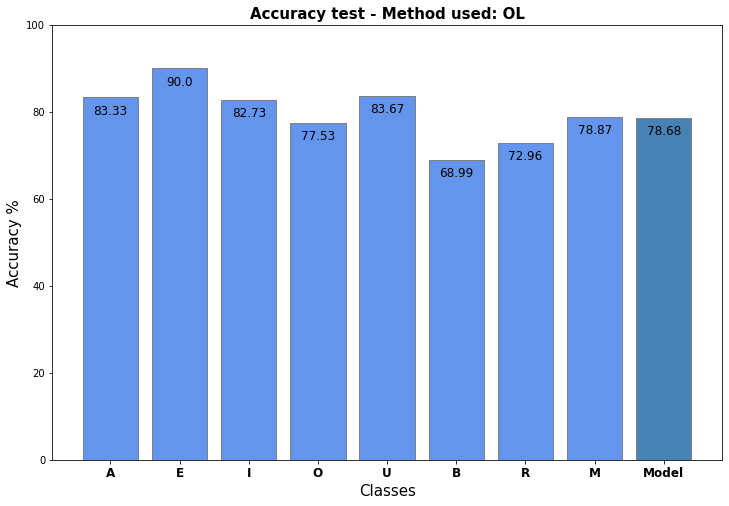

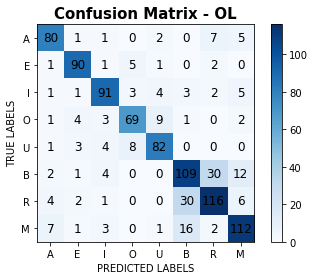

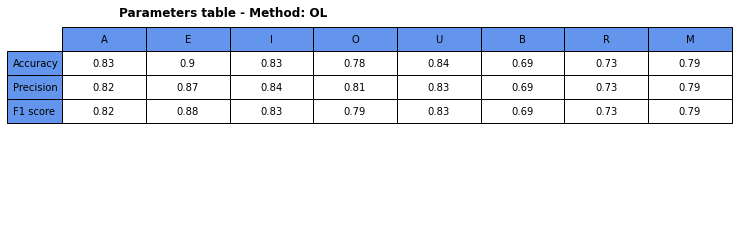

In [27]:
if(OL==1):
    Model_OL_all_mixed = Custom_Layer(model)
    Model_OL_all_mixed.title = 'OL' 
    Model_OL_all_mixed.filename = 'OL'
    Model_OL_all_mixed.l_rate = 0.001 # 0.05
    Model_OL_all_mixed.batch_size = batch_size_OL

    trainOneEpoch_OL(Model_OL_all_mixed, data_train, data_test, label_train, label_test)
    
    myWrite.save_PCconfMatrix(Model_OL_all_mixed)
    myBar.plot_barChart(Model_OL_all_mixed)
    myMatrix.plot_confMatrix(Model_OL_all_mixed)
    myTable.table_params(Model_OL_all_mixed)

### Train with OL + mini batch

In [28]:
if(OL_mini==1):
    Model_OL_mini = Custom_Layer(model)
    Model_OL_mini.title = 'OL + mini batch'
    Model_OL_mini.filename = 'OL_batches'
    Model_OL_mini.l_rate = 0.0001 #0.0001
    Model_OL_mini.batch_size = batch_size_OL

    trainOneEpoch_OL_miniBatch(Model_OL_mini, data_train, data_test, label_train, label_test)
    
    myWrite.save_PCconfMatrix(Model_OL_mini)
    myBar.plot_barChart(Model_OL_mini)
    myMatrix.plot_confMatrix(Model_OL_mini)
    myTable.table_params(Model_OL_mini)

### Train with OL v2

In [29]:
if(OL_v2==1):
    Model_OL_v2 = Custom_Layer(model)
    Model_OL_v2.title = 'OL v2' 
    Model_OL_v2.filename = 'OL_v2'
    Model_OL_v2.l_rate = 0.001
    Model_OL_v2.batch_size = batch_size_OL

    trainOneEpoch_OL_v2(Model_OL_v2, data_train, data_test, label_train, label_test)
    
    myWrite.save_PCconfMatrix(Model_OL_v2)
    myBar.plot_barChart(Model_OL_v2)
    myMatrix.plot_confMatrix(Model_OL_v2)
    myTable.table_params(Model_OL_v2)

### Train with OL V2 + mini batches

In [30]:
if(OL_v2_mini==1):
    Model_OL_v2_miniBatch = Custom_Layer(model)
    Model_OL_v2_miniBatch.title = 'OL v2 + mini batch'
    Model_OL_v2_miniBatch.filename = 'OL_v2_batches'
    Model_OL_v2_miniBatch.l_rate = 0.001 # 0.001
    Model_OL_v2_miniBatch.batch_size = batch_size_OL

    trainOneEpoch_OL_v2_miniBatch(Model_OL_v2_miniBatch, data_train, data_test, label_train, label_test)
    
    myWrite.save_PCconfMatrix(Model_OL_v2_miniBatch)
    myBar.plot_barChart(Model_OL_v2_miniBatch)
    myMatrix.plot_confMatrix(Model_OL_v2_miniBatch)
    myTable.table_params(Model_OL_v2_miniBatch)

### Train with LWF

In [31]:
if(LWF==1):
    Model_LWF_1 = Custom_Layer(model)
    Model_LWF_1.title = 'LWF'
    Model_LWF_1.filename = 'LWF'   
    Model_LWF_1.l_rate = 0.001
    Model_LWF_1.batch_size = batch_size_OL

    trainOneEpochOL_LWF(Model_LWF_1, data_train, data_test, label_train, label_test)   
    
    myWrite.save_PCconfMatrix(Model_LWF_1)
    myBar.plot_barChart(Model_LWF_1)
    myMatrix.plot_confMatrix(Model_LWF_1)
    myTable.table_params(Model_LWF_1)

### Train LWF + mini batches

In [32]:
if(LWF_mini==1):
    Model_LWF_2 = Custom_Layer(model)
    Model_LWF_2.title = 'LWF + mini batch'
    Model_LWF_2.filename = 'LWF_batches'
    Model_LWF_2.l_rate = 0.0007 #0.0007
    Model_LWF_2.batch_size = batch_size_OL

    trainOneEpochOL_LWF_v2(Model_LWF_2, data_train, data_test, label_train, label_test)
    
    myWrite.save_PCconfMatrix(Model_LWF_2)
    myBar.plot_barChart(Model_LWF_2)
    myMatrix.plot_confMatrix(Model_LWF_2)
    myTable.table_params(Model_LWF_2)

### Train with CWR

In [33]:
if(CWR==1):
    Model_CWR = Custom_Layer(model) 
    Model_CWR.title = 'CWR'
    Model_CWR.filename = 'CWR'
    Model_CWR.l_rate = 0.0005

    Model_CWR.batch_size = batch_size_OL

    trainOneEpoch_CWR(Model_CWR, data_train, data_test, label_train, label_test)
    
    myWrite.save_PCconfMatrix(Model_CWR)
    myBar.plot_barChart(Model_CWR)
    myMatrix.plot_confMatrix(Model_CWR)
    myTable.table_params(Model_CWR)

# RESULTS PLOTS

## All bar plots together

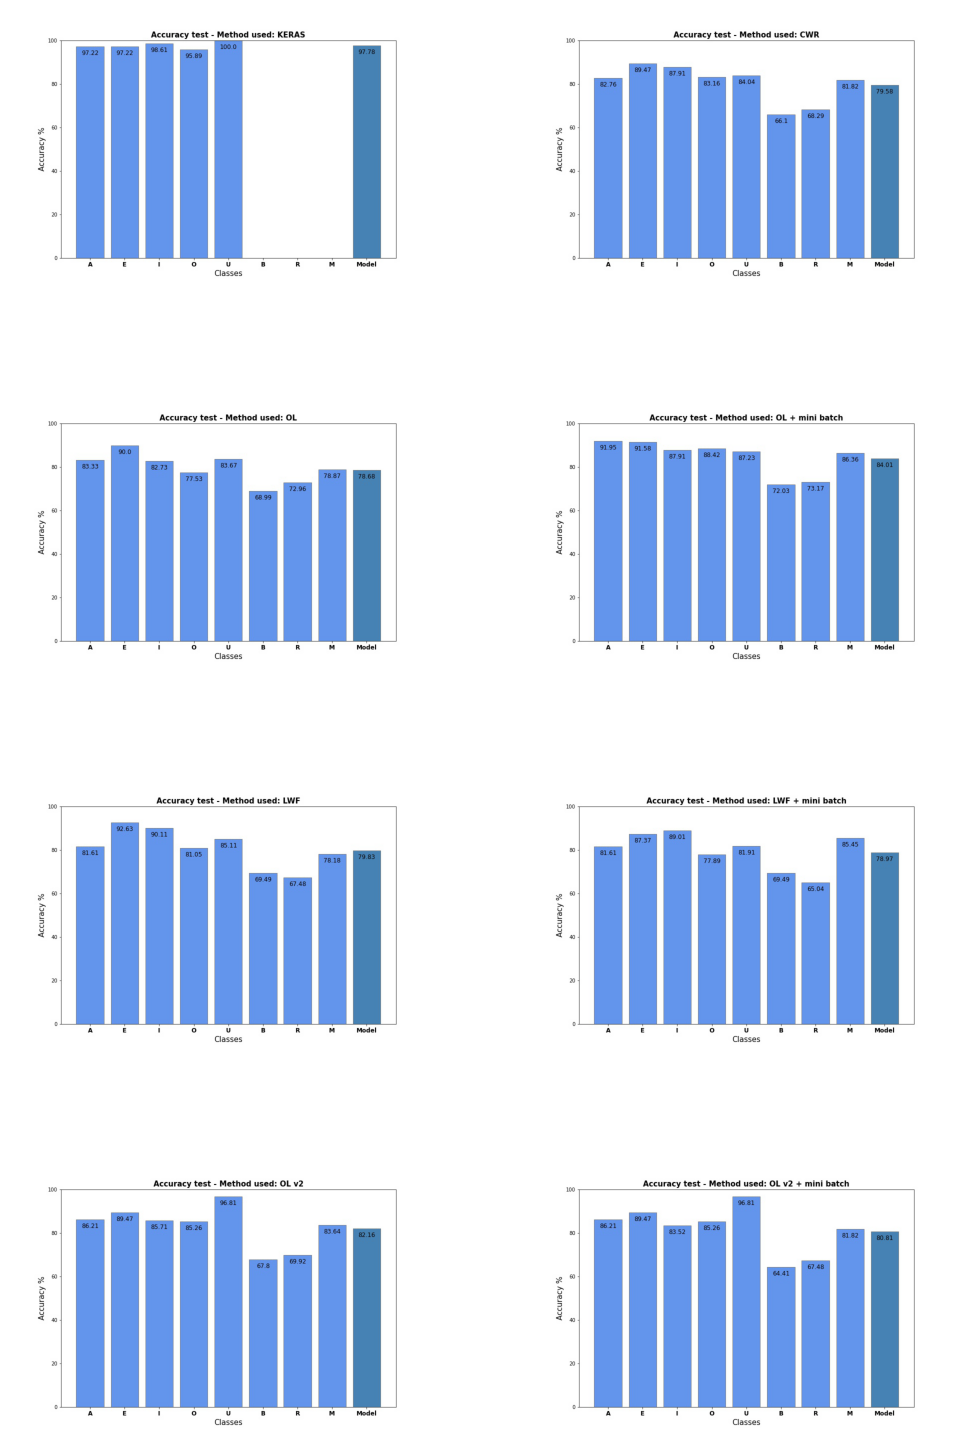

In [34]:
myBar.plot_barChart_All()

The following plot is a recap of all the methods trained. Note that it will be displayed only if all the training have been performed in this runtime. 
The table contains some additiona information and not only the accuracy.

In [35]:
if(KERAS and OL_vowels and OL and OL_mini and LWF and LWF_mini and OL_v2 and OL_v2_mini and CWR):
    
    myTable.table_simulationResult(Model_KERAS, Model_OL_all_mixed, Model_OL_mini, 
               Model_LWF_1, Model_LWF_2, Model_OL_v2, Model_OL_v2_miniBatch, Model_CWR)  

# DEBUG

Load weights, biases and the out of frozen layer from txt file

In [36]:
if(DEBUG_HISTORY==1):
    bias_stm       = myDebug.debug_loadBiasSMT()
    weight_stm     = myDebug.debug_loadWeightsSTM()
    frozenOut_stm  = myDebug.debug_loadFrozenOutSMT()
    softmax_stm    = myDebug.debug_loadSoftmaxSMT()
    preSoftmax_stm = myDebug.debug_loadPreSoftmaxSMT()

    max_dim = data_train.shape[0]

## CHECK ITERATION NUMBER X

labels is: E
The max difference is 0.00022924609373831117


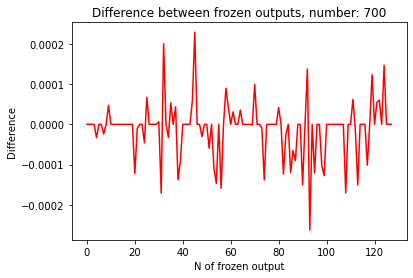

bias pc  -0.0037721 -0.0011617 0.0163322 -0.0026556 0.0039960 0.0020000 -0.0040000 -0.0030000
bias stm -0.0037721 -0.0011617 0.0163322 -0.0026556 0.0039960 0.0020000 -0.0040000 -0.0030000

weight pc  -0.0609128 -1.6796230 0.9882943 -0.1006709 0.0245481 -0.1819782 -0.0649826 -0.4311054
weight stm -0.0609136 -1.6796227 0.9882942 -0.1006708 0.0245481 -0.1819783 -0.0649828 -0.4311054

pre softmax pc  -9735.0369219 31715.7613976 -2174.3560883 -2978.8929626 -24881.3228410 5835.6689350 -10244.5852080 12774.0515614
pre softmax stm -9735.0392000 31715.7568000 -2174.3630000 -2978.8940000 -24881.3328000 5835.6792000 -10244.5944000 12774.0656000

softmax pc  0.0000000 1.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000
softmax stm 0.0000000 1.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.0000000


In [37]:
if(DEBUG_HISTORY==1):
    # put the number of the iteration you want to better check
    test_n = 700

    print(f'labels is: {label_train[test_n]}')
    myDebug.plot_frozenDifference(test_n, frozenOut_pc, frozenOut_stm)
    print(f'bias pc  {bias_pc[test_n,0]:.7f} {bias_pc[test_n,1]:.7f} {bias_pc[test_n,2]:.7f} {bias_pc[test_n,3]:.7f} {bias_pc[test_n,4]:.7f} {bias_pc[test_n,5]:.7f} {bias_pc[test_n,6]:.7f} {bias_pc[test_n,7]:.7f}')
    print(f'bias stm {bias_stm[test_n,0]:.7f} {bias_stm[test_n,1]:.7f} {bias_stm[test_n,2]:.7f} {bias_stm[test_n,3]:.7f} {bias_stm[test_n,4]:.7f} {bias_stm[test_n,5]:.7f} {bias_stm[test_n,6]:.7f} {bias_stm[test_n,7]:.7f}')
    print()
    print(f'weight pc  {weight_pc[test_n,5]:.7f} {weight_pc[test_n,15]:.7f} {weight_pc[test_n,25]:.7f} {weight_pc[test_n,35]:.7f} {weight_pc[test_n,45]:.7f} {weight_pc[test_n,55]:.7f} {weight_pc[test_n,65]:.7f} {weight_pc[test_n,75]:.7f}')
    print(f'weight stm {weight_stm[test_n,5]:.7f} {weight_stm[test_n,15]:.7f} {weight_stm[test_n,25]:.7f} {weight_stm[test_n,35]:.7f} {weight_stm[test_n,45]:.7f} {weight_stm[test_n,55]:.7f} {weight_stm[test_n,65]:.7f} {weight_stm[test_n,75]:.7f}')
    print()
    print(f'pre softmax pc  {preSoftmax_pc[test_n,0]:.7f} {preSoftmax_pc[test_n,1]:.7f} {preSoftmax_pc[test_n,2]:.7f} {preSoftmax_pc[test_n,3]:.7f} {preSoftmax_pc[test_n,4]:.7f} {preSoftmax_pc[test_n,5]:.7f} {preSoftmax_pc[test_n,6]:.7f} {preSoftmax_pc[test_n,7]:.7f}')
    print(f'pre softmax stm {preSoftmax_stm[test_n,0]:.7f} {preSoftmax_stm[test_n,1]:.7f} {preSoftmax_stm[test_n,2]:.7f} {preSoftmax_stm[test_n,3]:.7f} {preSoftmax_stm[test_n,4]:.7f} {preSoftmax_stm[test_n,5]:.7f} {preSoftmax_stm[test_n,6]:.7f} {preSoftmax_stm[test_n,7]:.7f}')
    print()
    print(f'softmax pc  {softmax_pc[test_n,0]:.7f} {softmax_pc[test_n,1]:.7f} {softmax_pc[test_n,2]:.7f} {softmax_pc[test_n,3]:.7f} {softmax_pc[test_n,4]:.7f} {softmax_pc[test_n,5]:.7f} {softmax_pc[test_n,6]:.7f} {softmax_pc[test_n,7]:.7f}')
    print(f'softmax stm {softmax_stm[test_n,0]:.7f} {softmax_stm[test_n,1]:.7f} {softmax_stm[test_n,2]:.7f} {softmax_stm[test_n,3]:.7f} {softmax_stm[test_n,4]:.7f} {softmax_stm[test_n,5]:.7f} {softmax_stm[test_n,6]:.7f} {softmax_stm[test_n,7]:.7f}')

In [38]:
if(DEBUG_HISTORY==1):
    # search where is the first big difference in PRE SOFTMAC
    iteratore = np.zeros(8)
    for j in range(0,8):
        for i in range(0, max_dim):
            diff = preSoftmax_pc[i,j] - preSoftmax_stm[i,j]
            if(diff>1):
                iteratore[j]=i
                break

    print(f'The biggest difference in the pre softmax is found at iter: {iteratore}')
    
    # search where is the first big difference in SOFTMAX
    iteratore = np.zeros(8)
    for j in range(0,8):
        for i in range(0, max_dim):
            diff = softmax_pc[i,j] - softmax_stm[i,j]
            if(diff>0.0001):
                iteratore[j]=i
                break

    print(f'The biggest difference in the softmax is found at iter:     {iteratore}')

The biggest difference in the pre softmax is found at iter: [0. 0. 0. 0. 0. 0. 0. 0.]
The biggest difference in the softmax is found at iter:     [0. 0. 0. 0. 0. 0. 0. 0.]


## CHECK PRE SOFTMAX

In [39]:
print(preSoftmax_pc[2,])

[ 516.57875749  409.45338879  760.35402626 -585.94144985 -341.98650009
    0.            0.            0.        ]


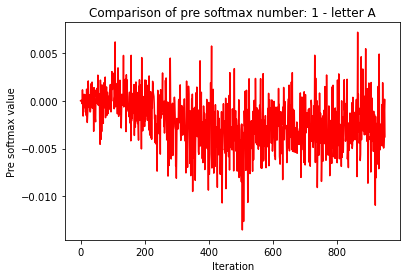

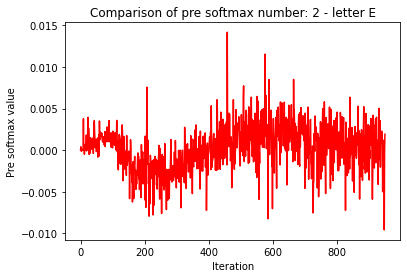

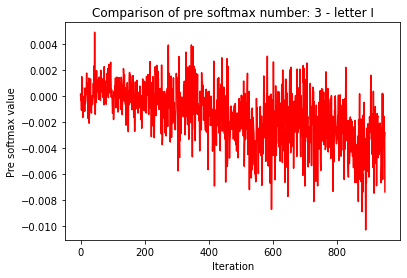

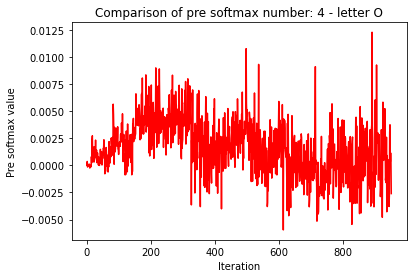

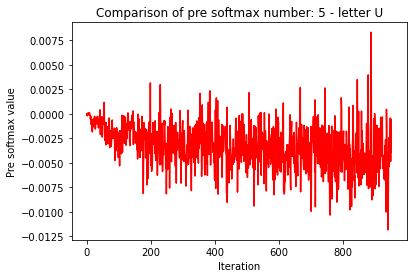

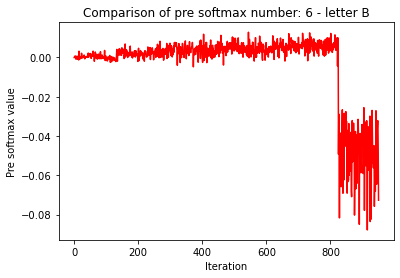

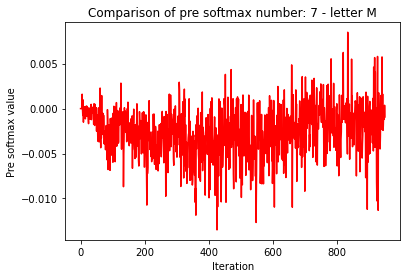

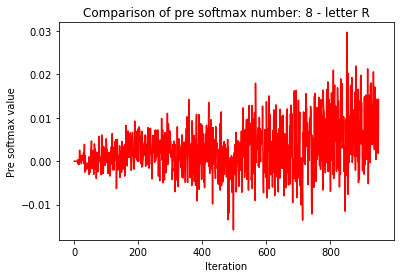

In [40]:
if(DEBUG_HISTORY==1):
    myDebug.debug_plotHistoryPreSoftmax(0, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryPreSoftmax(1, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryPreSoftmax(2, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryPreSoftmax(3, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryPreSoftmax(4, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryPreSoftmax(5, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryPreSoftmax(6, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryPreSoftmax(7, preSoftmax_pc, preSoftmax_stm, Model_OL_all_mixed.label, max_dim)

## CHECK SOFTMAX

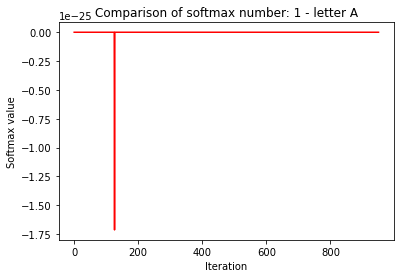

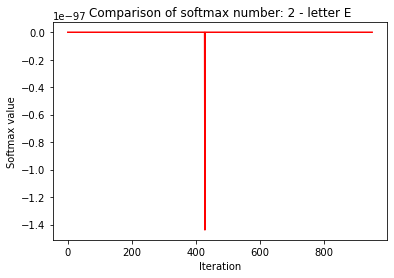

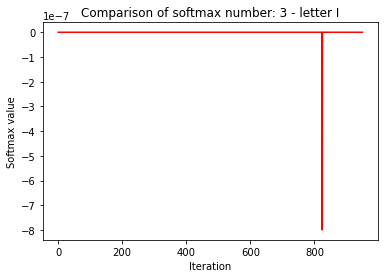

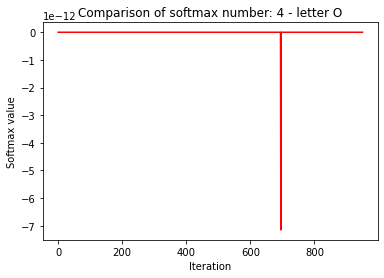

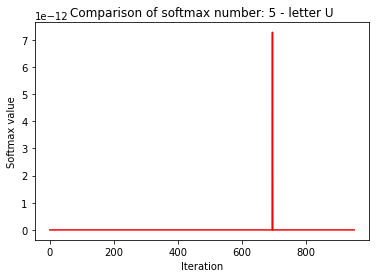

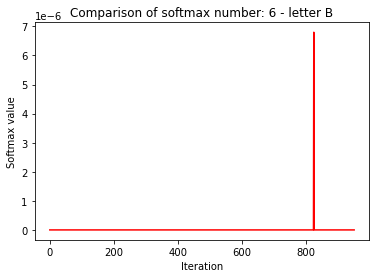

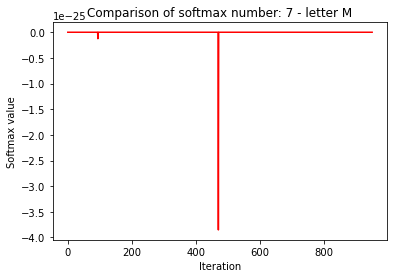

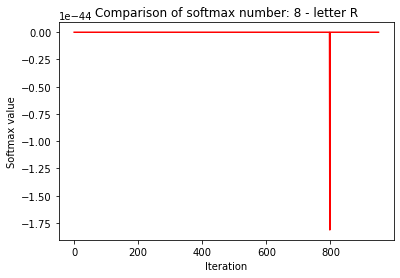

In [41]:
if(DEBUG_HISTORY==1):
    myDebug.debug_plotHistorySoftmax(0, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistorySoftmax(1, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistorySoftmax(2, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistorySoftmax(3, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistorySoftmax(4, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistorySoftmax(5, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistorySoftmax(6, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistorySoftmax(7, softmax_pc, softmax_stm, Model_OL_all_mixed.label, max_dim)

## CHECK BIAS

In [42]:
if(DEBUG_HISTORY==1):
    n_prova = max_dim-3 # check differences at last iteration
    myDebug.debug_confrontBias(n_prova, bias_stm, bias_pc, Model_OL_all_mixed.label) # max 771

Iteration number 948
n bias     vowel
  0          A             -0.00277205743       PC
                           -0.00277205700       STM
                            0.00000000043       difference 

  1          E             -0.00016165915       PC
                           -0.00016165900       STM
                            0.00000000015       difference 

  2          I              0.01733221343       PC
                            0.01733221200       STM
                           -0.00000000143       difference 

  3          O             -0.00465558623       PC
                           -0.00465558600       STM
                            0.00000000023       difference 

  4          U              0.00499603585       PC
                            0.00499603600       STM
                            0.00000000015       difference 

  5          B              0.00300000680       PC
                            0.00300000000       STM
                           -0.000000006

The final values are:
          PC:-0.00277205743
         STM:-0.00277205700
  difference:-0.00000000043  - which is 0.0%


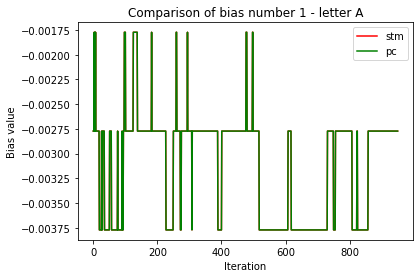

The final values are:
          PC:-0.00016165915
         STM:-0.00016165900
  difference:-0.00000000015  - which is 0.0%


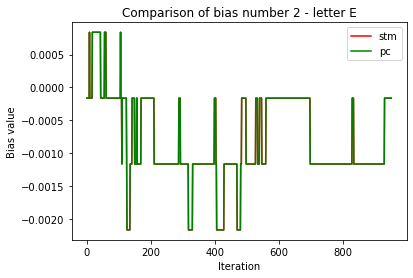

The final values are:
          PC:0.01733221343
         STM:0.01733221200
  difference:0.00000000143  - which is 0.0%


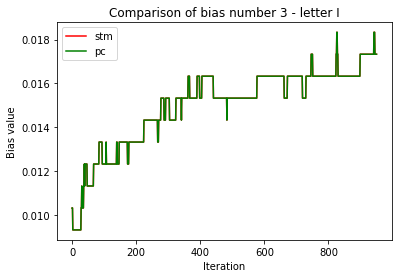

The final values are:
          PC:-0.00465558623
         STM:-0.00465558600
  difference:-0.00000000023  - which is 0.0%


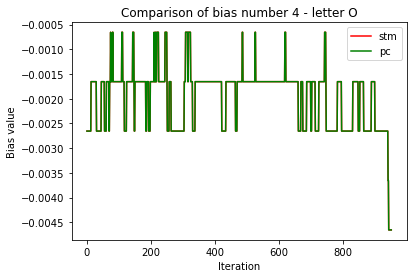

The final values are:
          PC:0.00499603585
         STM:0.00499603600
  difference:-0.00000000015  - which is 0.0%


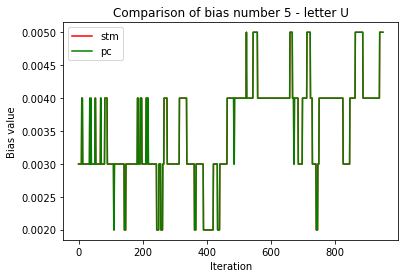

The final values are:
          PC:0.00300000680
         STM:0.00300000000
  difference:0.00000000680  - which is 0.0%


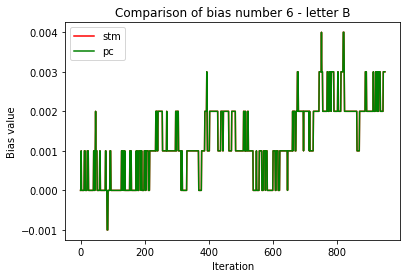

The final values are:
          PC:-0.00600000000
         STM:-0.00600000000
  difference:0.00000000000  - which is 0.0%


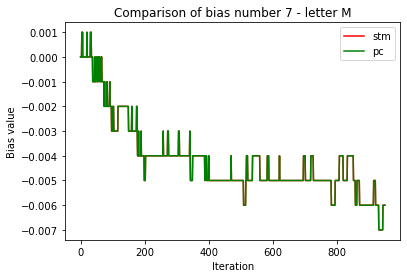

The final values are:
          PC:-0.00400000000
         STM:-0.00400000000
  difference:0.00000000000  - which is 0.0%


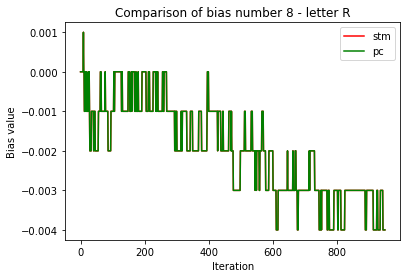

In [43]:
if(DEBUG_HISTORY==1):
    myDebug.debug_plotHistoryBias(0, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryBias(1, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryBias(2, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryBias(3, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryBias(4, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryBias(5, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryBias(6, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)
    myDebug.debug_plotHistoryBias(7, bias_stm, bias_pc, Model_OL_all_mixed.label, max_dim)

## CHECK WEIGHTS

In [44]:
if(DEBUG_HISTORY==1):
    n_prova = max_dim-1
    
    weight_num = [2,5,8,11,14,17,20,23,26,29,32,35,38,41,44,47,50,53,56,59,62,65,68,71,74,77]

    myDebug.debug_confrontWeights(n_prova, weight_stm, weight_pc, weight_num, selected_w)

Iteration number 950
n weight
  107             -0.96976494247       PC
                 -0.96976528000       STM
                 -0.00000033753       difference 

  65              1.33049571216       PC
                  1.33049536000       STM
                 -0.00000035216       difference 

  89             -0.09848526120       PC
                 -0.09848526000       STM
                  0.00000000120       difference 

  239             -0.57558003487       PC
                 -0.57558000000       STM
                  0.00000003487       difference 

  207             -1.77737034598       PC
                 -1.77737056000       STM
                 -0.00000021402       difference 

  230              0.26310586882       PC
                  0.26310592000       STM
                  0.00000005118       difference 

  374             -2.25398132156       PC
                 -2.25398080000       STM
                  0.00000052156       difference 

  371              0.013491

In [45]:
itr = 700
print(weight_stm[itr,50])
print(weight_pc[itr,51])

-1.02114144
-0.7984100073575974


The final values are:
             PC:-0.96976494247
            STM:-0.96976528000
  difference:0.00000033753  - which is 0.0%


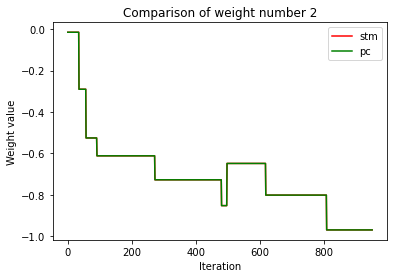

The final values are:
             PC:1.33049571216
            STM:1.33049536000
  difference:0.00000035216  - which is 0.0%


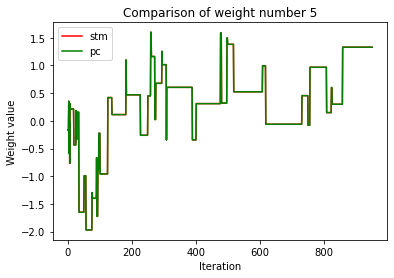

The final values are:
             PC:-0.09848526120
            STM:-0.09848526000
  difference:-0.00000000120  - which is 0.0%


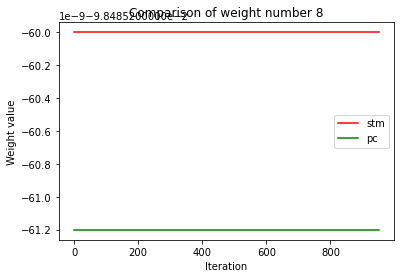

The final values are:
             PC:-0.57558003487
            STM:-0.57558000000
  difference:-0.00000003487  - which is 0.0%


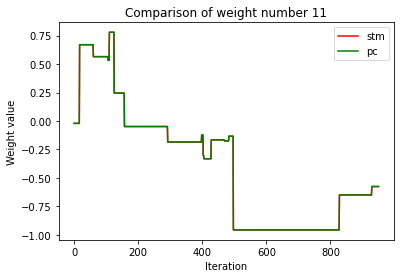

The final values are:
             PC:-1.77737034598
            STM:-1.77737056000
  difference:0.00000021402  - which is 0.0%


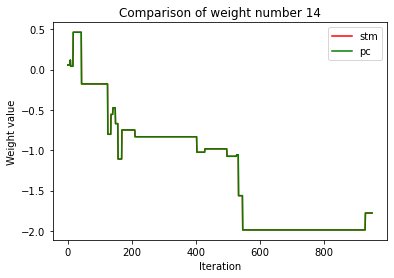

The final values are:
             PC:0.26310586882
            STM:0.26310592000
  difference:-0.00000005118  - which is 0.0%


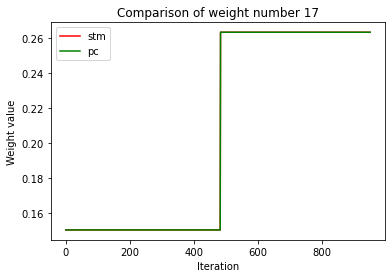

The final values are:
             PC:-2.25398132156
            STM:-2.25398080000
  difference:-0.00000052156  - which is 0.0%


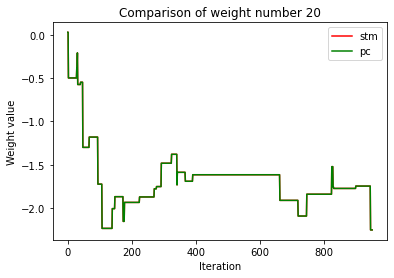

The final values are:
             PC:0.01349152613
            STM:0.01349138000
  difference:0.00000014613  - which is 0.0%


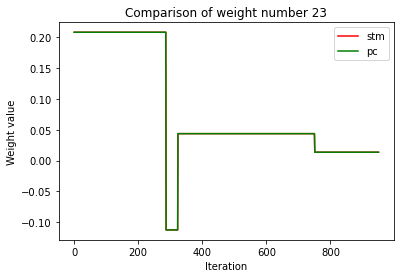

The final values are:
             PC:-1.91218403140
            STM:-1.91218400000
  difference:-0.00000003140  - which is 0.0%


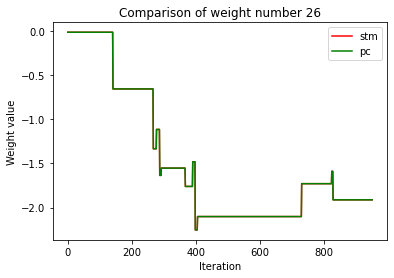

The final values are:
             PC:-0.03416104242
            STM:-0.03416104000
  difference:-0.00000000242  - which is 0.0%


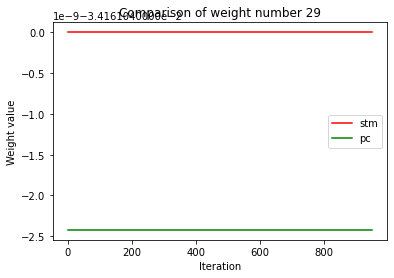

The final values are:
             PC:0.26048653662
            STM:0.26048648000
  difference:0.00000005662  - which is 0.0%


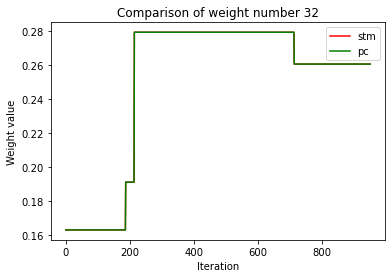

The final values are:
             PC:-0.10067089987
            STM:-0.10067078000
  difference:-0.00000011987  - which is 0.0%


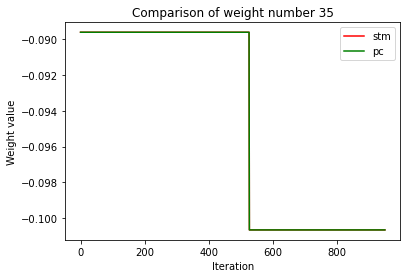

The final values are:
             PC:0.26048653662
            STM:0.26048648000
  difference:0.00000005662  - which is 0.0%


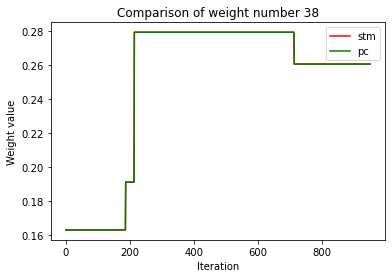

The final values are:
             PC:-1.09675338721
            STM:-1.09675360000
  difference:0.00000021279  - which is 0.0%


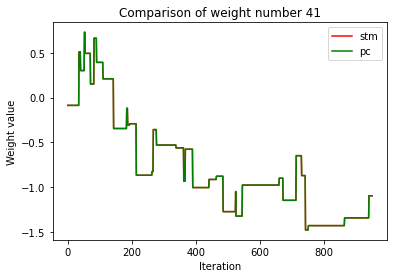

The final values are:
             PC:0.18039071560
            STM:0.18039072000
  difference:-0.00000000440  - which is 0.0%


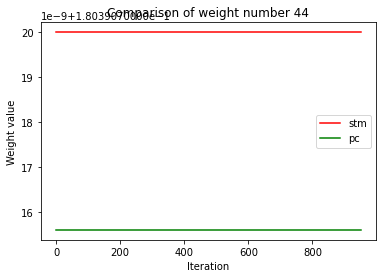

The final values are:
             PC:-0.25049892431
            STM:-0.25049958000
  difference:0.00000065569  - which is 0.0%


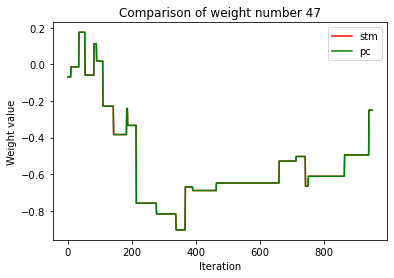

The final values are:
             PC:-1.12453386402
            STM:-1.12453400000
  difference:0.00000013598  - which is 0.0%


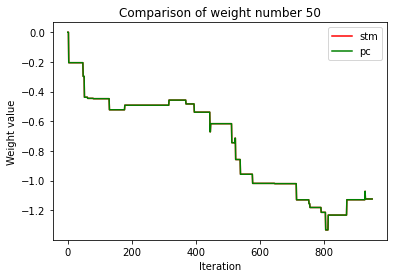

The final values are:
             PC:0.05062869644
            STM:0.05062871000
  difference:-0.00000001356  - which is 0.0%


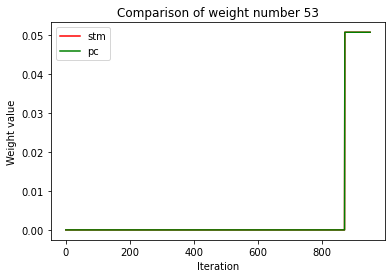

The final values are:
             PC:0.00000000000
            STM:0.00000000000
  difference:0.00000000000  - which is 0%


C:\Users\massi\UNI\Magistrale\Anno 5\Semestre 2\Tesi\Code\Letters_application\Python\myLib_debugFiles.py:105: RuntimeWarning: invalid value encountered in double_scalars
  if(diff/max_val > 0.05):


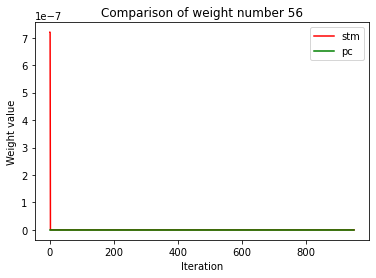

The final values are:
             PC:-1.40273460484
            STM:-1.40273488000
  difference:0.00000027516  - which is 0.0%


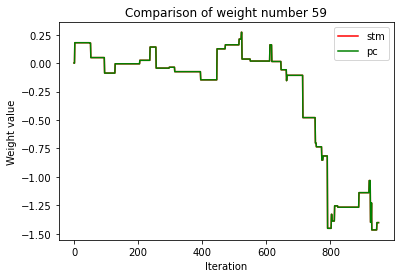

The final values are:
             PC:-2.22212949371
            STM:-2.22213056000
  difference:0.00000106629  - which is 0.0%


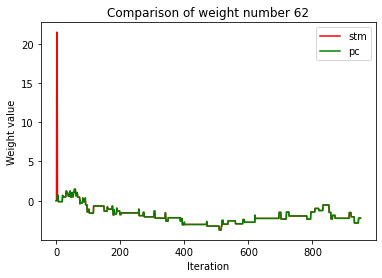

The final values are:
             PC:-0.16844293118
            STM:-0.16844312000
  difference:0.00000018882  - which is 0.0%


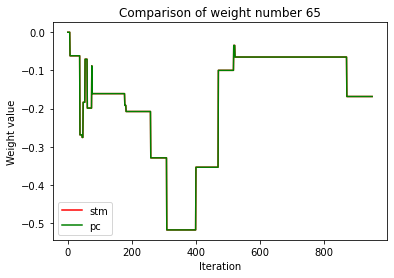

The final values are:
             PC:-3.15915789795
            STM:-3.15915872000
  difference:0.00000082205  - which is 0.0%


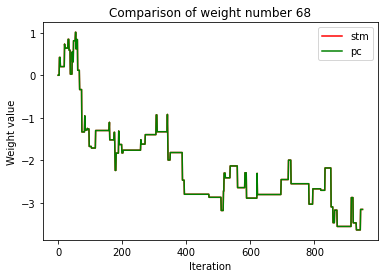

The final values are:
             PC:0.69279248834
            STM:0.69279248000
  difference:0.00000000834  - which is 0.0%


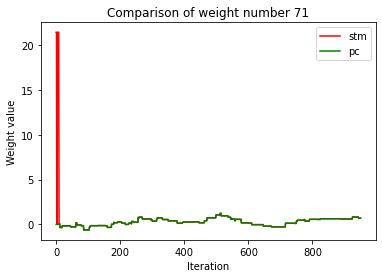

The final values are:
             PC:0.38296522141
            STM:0.38296532000
  difference:-0.00000009859  - which is 0.0%


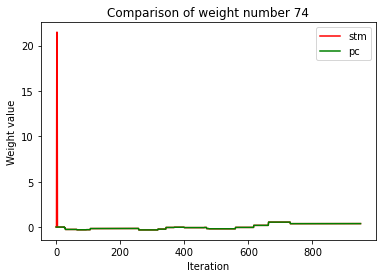

The final values are:
             PC:0.00000000000
            STM:0.00000000000
  difference:0.00000000000  - which is 0%


C:\Users\massi\UNI\Magistrale\Anno 5\Semestre 2\Tesi\Code\Letters_application\Python\myLib_debugFiles.py:105: RuntimeWarning: invalid value encountered in double_scalars
  if(diff/max_val > 0.05):


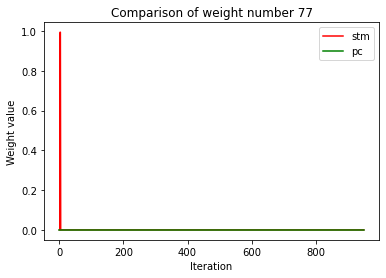

In [46]:
if(DEBUG_HISTORY==1):
    i=2
    while i < 80:
        myDebug.debug_plotHistoryWeight(i, weight_stm, weight_pc, max_dim)
        i+=3


## CHECK FROZEN OUTPUT

In [47]:
if(DEBUG_HISTORY==1):
    max_val = 0
    itr_1   = 0
    itr_2   = 0
    for i in range(61,max_dim):
        diff = frozenOut_pc[i,:] - frozenOut_stm[i,:]
        for j in range(0, len(diff)):
            diff[j] = np.abs(diff[j])
        if(max(diff)> max_val):
            max_val = max(diff)
            itr_1 = i
            itr_2 = np.argmax(diff)

    print(f'The max values of frozen ML output difference of all {frozenOut_stm.shape[0]} iteration is: {S_BOLD}{max_val:.11f}{E_BOLD}')
    print(f'The max difference is found at the iteration number: {S_BOLD}{itr_1}{E_BOLD}')
    print(f'At the position in the frozen output: {S_BOLD}{itr_2}/128{E_BOLD}')

The max values of frozen ML output difference of all 951 iteration is: 493.27758346875
The max difference is found at the iteration number: 544
At the position in the frozen output: 30/128


The max difference is 493.27758346875


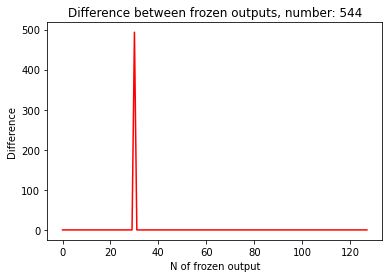

In [48]:
if(DEBUG_HISTORY==1):
    myDebug.plot_frozenDifference(544, frozenOut_pc, frozenOut_stm)

In [49]:
if(DEBUG_HISTORY==1):
    new_container = np.zeros(frozenOut_stm.shape)

    for j in range(0, frozenOut_stm.shape[0]):
        for i in range(0, frozenOut_stm.shape[1]):
            max_val = max(frozenOut_pc[j,i], frozenOut_pc[j,i])
            if(max_val != 0):
                diff = frozenOut_pc[j,i]-frozenOut_stm[j,i]
                new_container[j,i] = diff/max_val


    max_val =0
    for j in range(0, frozenOut_stm.shape[0]):
        if(max_val < max(new_container[i,:])):
            max_val = max(new_container[i,:])

    print(f'The max percentage error committed between stm and laptop is of: {max_val:.11f}')
    print(f'Percentage at position, 237, 79 is {new_container[237,79]}')

The max percentage error committed between stm and laptop is of: 0.00000299435
Percentage at position, 237, 79 is 5.087138050949562e-08
